# WASP-80b broadband analysis: GP Hyperparameter estimation 

In [1]:
%pylab inline
%run __init__.py

Populating the interactive namespace from numpy and matplotlib


In [2]:
from exotk.utils.misc import fold
from src.extcore import *
from scipy.optimize import minimize

lpf = LPFTM()
pv0 = pd.read_hdf(RFILE_EXT,'ckwn/fc').median().values

In [3]:
from george.kernels import ConstantKernel, ExpKernel, Matern32Kernel, ExpSquaredKernel

class GPTime(object):
    def __init__(self, inputs, flux):
        self.inputs = array(inputs)
        self.flux = array(flux)
        self.wn_estimate = diff(flux).std() / sqrt(2)
        self.gp = GP(self.kernel, white_noise=log(self.wn_estimate**2), fit_white_noise=True)
        self.gp.compute(self.inputs)
        self._minres = None
        self.hp = self.gp.get_parameter_vector()
        self.names = 'ln_wn_var ln_output_var ln_input_scale'.split()

    def compute(self, pv=None):
        if pv is not None:
            self.gp.set_parameter_vector(pv)
        self.gp.compute(self.inputs)

    def predict(self, pv=None, flux=None):
        if pv is not None:
            self.compute(pv)
        flux = flux if flux is not None else self.flux
        return self.gp.predict(flux, self.inputs, return_cov=False)

    def lnposterior(self, pv):
        self.compute(pv)
        return self.gp.lnlikelihood(self.flux)

    def nll(self, pv):
        return self.gp.nll(pv, self.flux)
    
    def grad_nll(self, pv):
        return self.gp.grad_nll(pv, self.flux)
    
    def minfun(self, pv):
        return -self.lnposterior(pv)

    def fit(self, pv0=None, disp=False):
        self._minres =  minimize(self.nll, self.gp.get_parameter_vector(), jac=self.grad_nll)
        self.hp[:] = self._minres.x.copy()
        return self.hp

    @property
    def kernel(self):
        return ( ConstantKernel(log(self.flux.var()), ((-20, -2),))
               * ExpKernel(0.1, metric_bounds=((-20, 5),)))

In [4]:
fluxes_m = lpf.compute_transit(pv0)
residuals = [fo-fm for fo,fm in zip(lpf.fluxes, fluxes_m)]
gps = [GPTime(time, res) for time,res in zip(lpf.times, residuals)]
hps = []

## Light curves

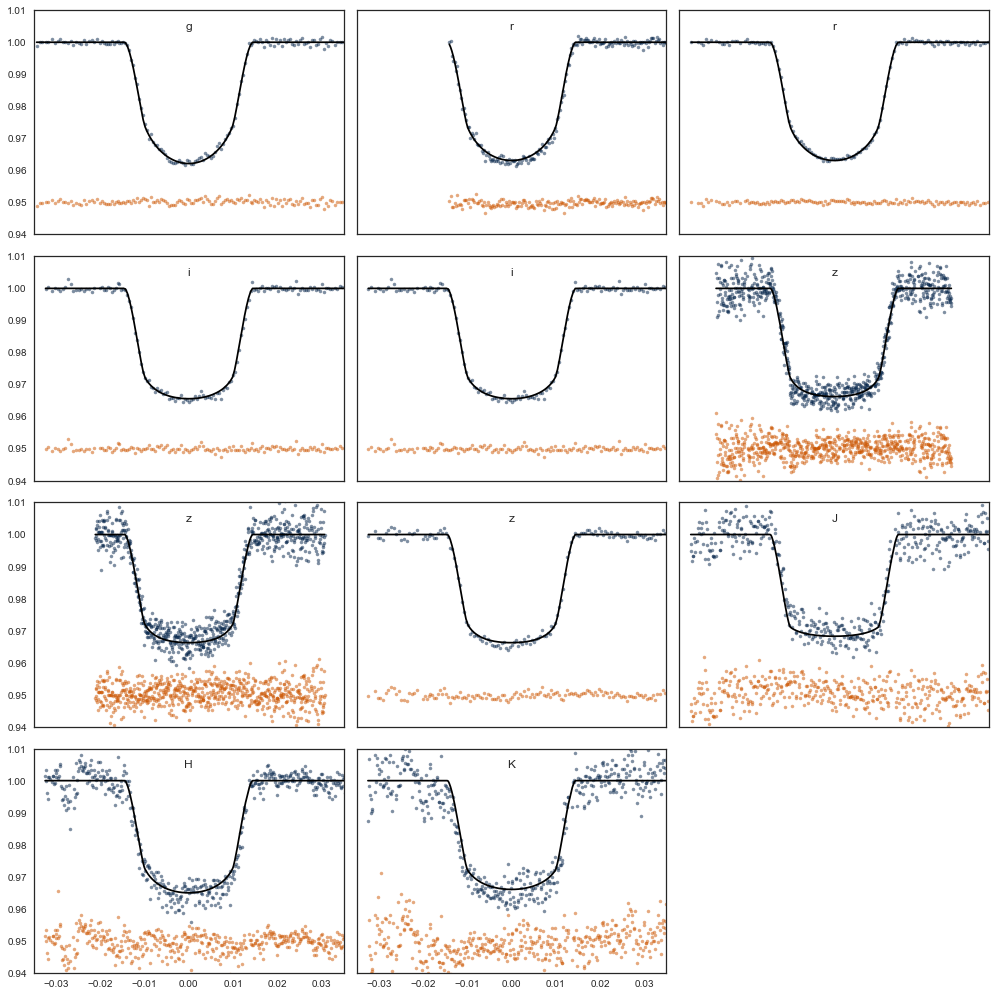

In [5]:
phases = list(map(lambda t: fold(t, P, TC, 0.5)-0.5, lpf.times))
fig,axs = subplots(4,3, figsize=(14,14),sharey=True, sharex=True)
for iax,ilc in enumerate(lpf.lcorder):
    a = axs.flat[iax]
    a.plot(phases[ilc], lpf.fluxes[ilc],'.', alpha=0.5)
    a.plot(phases[ilc], fluxes_m[ilc],'k')
    a.plot(phases[ilc], lpf.fluxes[ilc]-fluxes_m[ilc]+0.95,'.', alpha=0.5)
    a.text(0.5, 0.95, lpf.passbands[ilc], ha='center', va='top', size=12, transform=a.transAxes)
setp(axs, ylim=(0.94,1.01), xlim=(-0.035,0.035))
fig.tight_layout()
axs.flat[-1].set_visible(False)

In [6]:
hps = []
for gp in tqdm(gps, desc='Optimising GP hyperparameters'):
    gp.fit()
    hps.append(gp.hp)

Optimising GP hyperparameters: 100%|██████████| 11/11 [00:05<00:00,  3.03it/s]


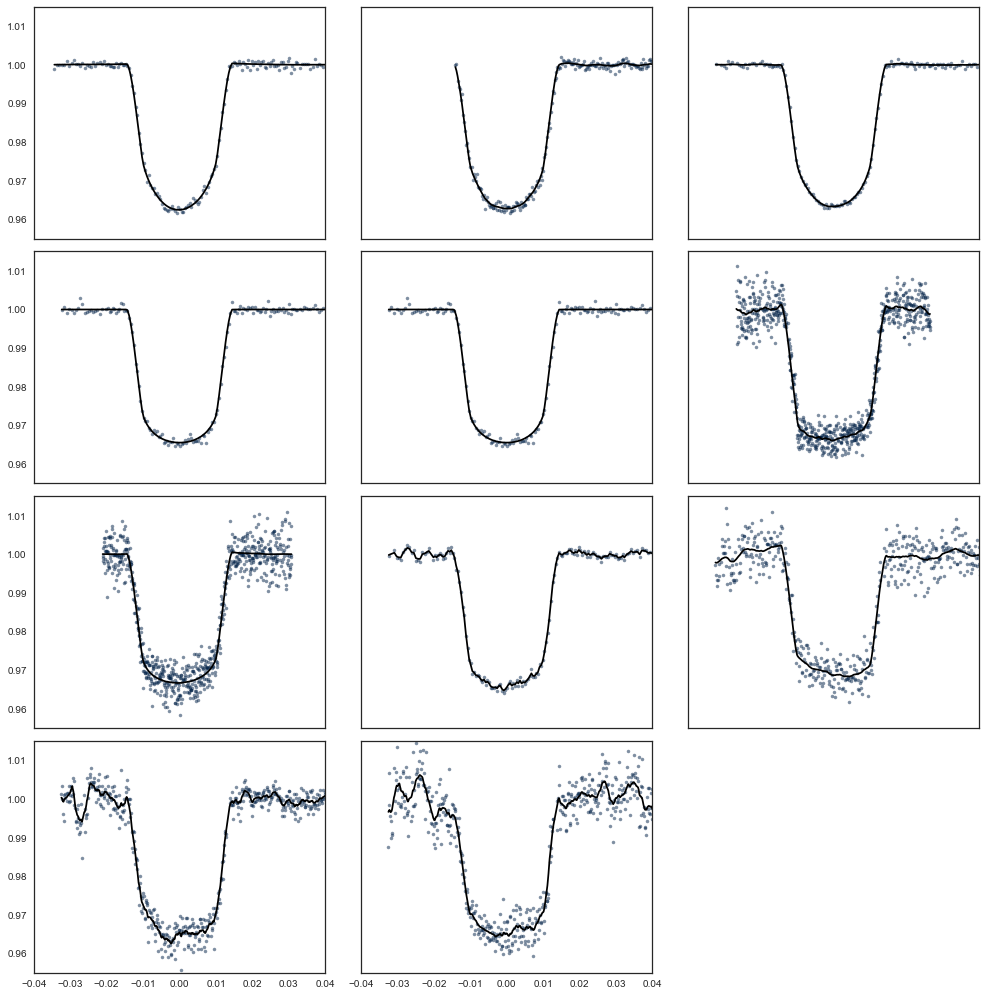

In [7]:
fig,axs = subplots(4,3, figsize=(14,14),sharey=True, sharex=True)
for iax,ilc in enumerate(lpf.lcorder):
    axs.flat[iax].plot(phases[ilc], lpf.fluxes[ilc], '.', alpha=0.5)
    gps[ilc].compute(hps[ilc])
    pr = gps[ilc].predict()
    axs.flat[iax].plot(phases[ilc], fluxes_m[ilc]+pr, 'k')
setp(axs, ylim=(0.955,1.015), xlim=(-0.04,0.04))
fig.tight_layout()
axs.flat[-1].set_visible(False)

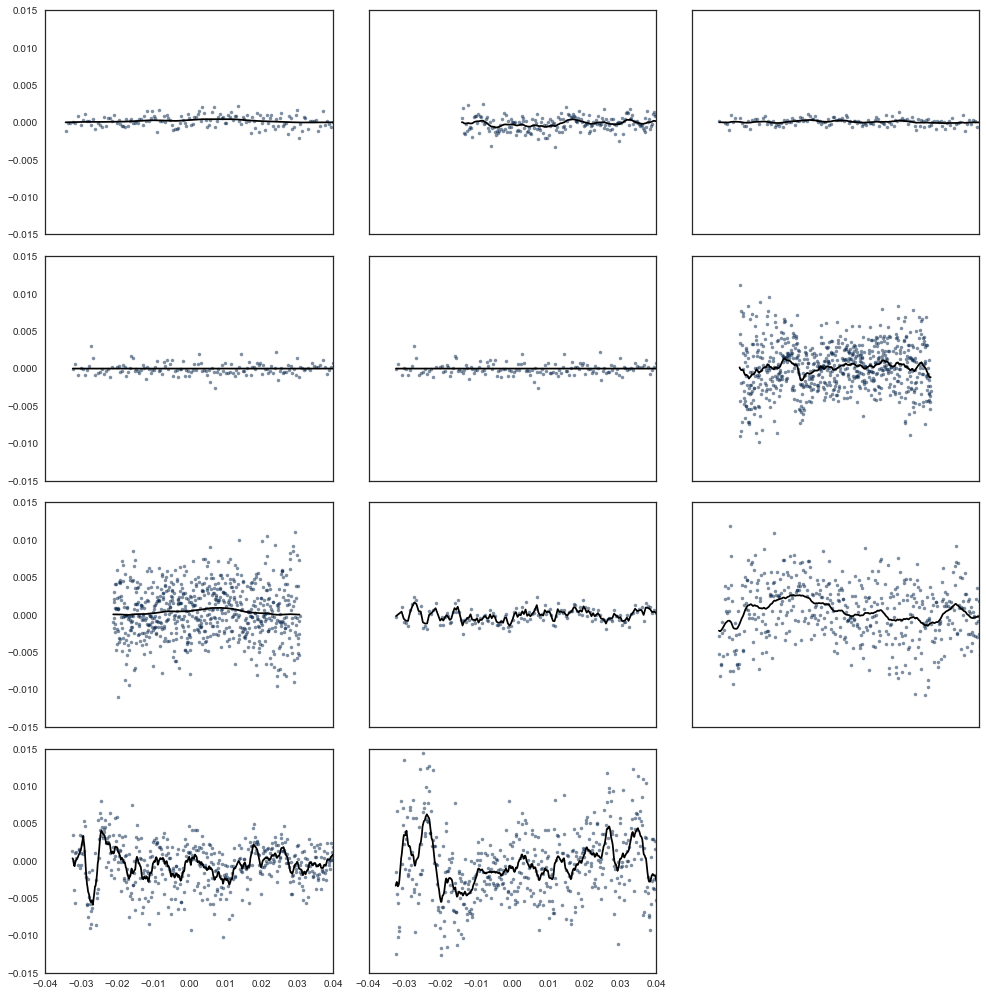

In [8]:
fig,axs = subplots(4,3, figsize=(14,14),sharey=True, sharex=True)
for iax,ilc in enumerate(lpf.lcorder):
    axs.flat[iax].plot(phases[ilc], gps[ilc].flux, '.', alpha=0.5)
    gps[ilc].compute(hps[ilc])
    pr = gps[ilc].predict()
    axs.flat[iax].plot(phases[ilc], pr, 'k')
setp(axs, ylim=(-0.015,.015), xlim=(-0.04,0.04))
fig.tight_layout()
axs.flat[-1].set_visible(False)

In [9]:
with pd.HDFStore(DFILE_EXT) as f:
    ntr = [k[3:] for k in f.keys() if 'lc/triaud' in k]
    nma = [k[3:] for k in f.keys() if 'lc/mancini' in k]

df = pd.DataFrame(hps, columns=gp.names, index=lpf.passbands)
df['lc_name'] = ntr+nma
df

,ln_wn_var,ln_output_var,ln_input_scale,lc_name
r,-14.061009,-15.602592,-9.482634,/triaud2013/r/eulercam_1
z,-11.538013,-14.091494,-11.006470,/triaud2013/z/trappist_1
z,-11.326154,-15.159640,-6.415521,/triaud2013/z/trappist_2
H,-11.992534,-12.533673,-10.651665,/mancini2014/H/grond
J,-11.255762,-13.003909,-8.117159,/mancini2014/J/grond
K,-10.953819,-11.730327,-9.770935,/mancini2014/K/grond
g,-14.402214,-16.615069,-5.768119,/mancini2014/g/grond
i,-14.382229,-19.947565,-1.572956,/mancini2014/i/dfosc
i,-14.382229,-19.947565,-1.572956,/mancini2014/i/grond
r,-15.508300,-17.281088,-9.295438,/mancini2014/r/grond


In [10]:
df.ix[:3].to_hdf(RFILE_EXT, 'gphp/triaud2013')
df.ix[3:].to_hdf(RFILE_EXT, 'gphp/mancini2014')

---

<center> &copy; 2017 <a href="mailto:hannu@iac.es">Hannu Parviainen</a></center>